In [26]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.impute import SimpleImputer
import numpy as np

In [56]:
def load_data():
    df = pd.read_csv('../data/kzhan176/citizens_data/BrownDSI_masked_capstone_data.csv_20250401031515')
    return df

In [57]:
df = load_data()

In [7]:
prevtran_cols = [f'prevtran{i}' for i in range(1, 11)]
prevtrandate_cols = [f'prevtrandate{i}' for i in range(1, 11)]

In [20]:
def prevtran_missing_imputation(df, flag="zero"):
    if flag == "zero":
        prevtran_cols = [f'prevtran{i}' for i in range(1, 11)]
        imputer = SimpleImputer(strategy='constant', fill_value=0)
        df[prevtran_cols] = imputer.fit_transform(df[prevtran_cols])
    else:
        raise ValueError(f"Invalid flag: {flag}. Only 'zero' is supported.")

In [37]:
def prevtrandate_missing_imputation(df, flag="prevdate"):

    if flag == "prevdate":
        def impute_prevtrandate(row):
            # Find the last available value (starting from 10 to 1)
            for i in reversed(range(10)):
                val = row[prevtrandate_cols[i]]
                if not pd.isna(val):
                    return row.fillna(val)
            return row.fillna(0)

        prevtrandate_cols = [f'prevtrandate{i}' for i in range(1, 11)]
        df[prevtrandate_cols] = df[prevtrandate_cols].apply(impute_prevtrandate, axis=1)
    else:
        raise ValueError(f"Invalid flag: {flag}. Only 'prevdate' is supported.")

In [36]:
def check_prevtran_imputed(df):
    prevtran_cols = [f'prevtran{i}' for i in range(1, 11)]
    prevtrandate_cols = [f'prevtrandate{i}' for i in range(1, 11)]
    cols_to_check = prevtran_cols + prevtrandate_cols

    missing = df[cols_to_check].isnull().any()
    return not missing.any()

In [39]:
from statsmodels.tsa.stattools import acf, pacf

def compute_acf_pacf(row):
    x = row.values.astype(float)
    acf_lag1 = acf(x, nlags=1, fft=False)[1]
    pacf_lag1 = pacf(x, nlags=1)[1]

    return pd.Series([acf_lag1, pacf_lag1])

In [42]:
def prevtran_preprocessing(df):
    '''
    modified features:
    - prevtran*: impute with 0, log transformation
    - prevtrandate*: impute with prev date

    added features:
    - isoutlier_prevtran: add extreme transaction amount in prev as a signal
    - prevtran_diff1: Most recent change (e.g., tran1 - tran2)
    - prevtran_ratio1: ratio of the most recent transaction amount (prevtran1) to the second most recent (prevtran2)
    - prevtran_mean, prevtran_median, prevtran_std, prevtran_sum, prevtran_valid_count: 
            Mean, median, std, min, max, and sum across previous transactions
    - acf_lag1, pacf_lag1: timeseries features
    '''

    # Mean, median, std, min, max, and sum across previous transactions, 
    # preserve absence of behavior in the statistics by computing before imputing
    prevtran_cols = [f'prevtran{i}' for i in range(1, 11)]
    df['prevtran_mean'] = df[prevtran_cols].mean(axis=1, skipna=True)
    df['prevtran_median'] = df[prevtran_cols].median(axis=1, skipna=True)
    df['prevtran_std'] = df[prevtran_cols].std(axis=1, skipna=True)
    df['prevtran_sum'] = df[prevtran_cols].sum(axis=1, skipna=True)
    df['prevtran_valid_count'] = df[prevtran_cols].notnull().sum(axis=1)

    # impute missing values
    prevtran_missing_imputation(df)
    prevtrandate_missing_imputation(df)
    if not check_prevtran_imputed:
        raise ValueError(f"Imputation incomplete: Some prevtran/prevtrandate values are still missing.")
    
    # add an isoutlier column to preserve extreme behavior as a signal
    threshold = df[prevtran_cols].stack().quantile(0.99)
    df['isoutlier_prevtran'] = (df[prevtran_cols].max(axis=1) > threshold).astype(int)

    # take log of prevtran*, since data right-skewed, clip if using non-tree based methods?
    df[prevtran_cols] = df[prevtran_cols].applymap(lambda x: np.log1p(x) if x > 0 else 0)

    # prevtran_diff1
    df['prevtran_diff1'] = df['prevtran1'] - df['prevtran2']

    # prevtran_ratio1
    df['prevtran_ratio1'] = df['prevtran1'] / (df['prevtran2'] + 1e-5)
    
    # timeseries features: acf, pacf
    df[['acf_lag1', 'pacf_lag1']] = df[prevtran_cols].apply(compute_acf_pacf, axis=1)

prevtran_preprocessing(df)

/tmp/ipykernel_1970996/2740088492.py:36: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  df[prevtran_cols] = df[prevtran_cols].applymap(lambda x: np.log1p(x) if x > 0 else 0)
/users/kzhan176/.conda/envs/citizens/lib/python3.12/site-packages/statsmodels/tsa/stattools.py:702: RuntimeWarning: invalid value encountered in divide
  acf = avf[: nlags + 1] / avf[0]
/users/kzhan176/.conda/envs/citizens/lib/python3.12/site-packages/statsmodels/regression/linear_model.py:1490: ValueWarning: Matrix is singular. Using pinv.
  warnings.warn("Matrix is singular. Using pinv.", ValueWarning)
/users/kzhan176/.conda/envs/citizens/lib/python3.12/site-packages/statsmodels/tsa/stattools.py:702: RuntimeWarning: invalid value encountered in divide
  acf = avf[: nlags + 1] / avf[0]
/users/kzhan176/.conda/envs/citizens/lib/python3.12/site-packages/statsmodels/regression/linear_model.py:1490: ValueWarning: Matrix is singular. Using pinv.
  warnings.warn("Matrix is singular. U

In [43]:
# check preprocessing and feature engineering results
prevtran_cols = [f'prevtran{i}' for i in range(1, 11)]
prevtrandate_cols = [f'prevtrandate{i}' for i in range(1, 11)]

engineered_cols = [
    'prevtran_mean', 'prevtran_median', 'prevtran_std', 'prevtran_sum', 'prevtran_valid_count',
    'isoutlier_prevtran', 'prevtran_diff1', 'prevtran_ratio1',
    'acf_lag1', 'pacf_lag1'
]

all_corr_cols = prevtran_cols + prevtrandate_cols + engineered_cols

corr_matrix = df[all_corr_cols].corr()

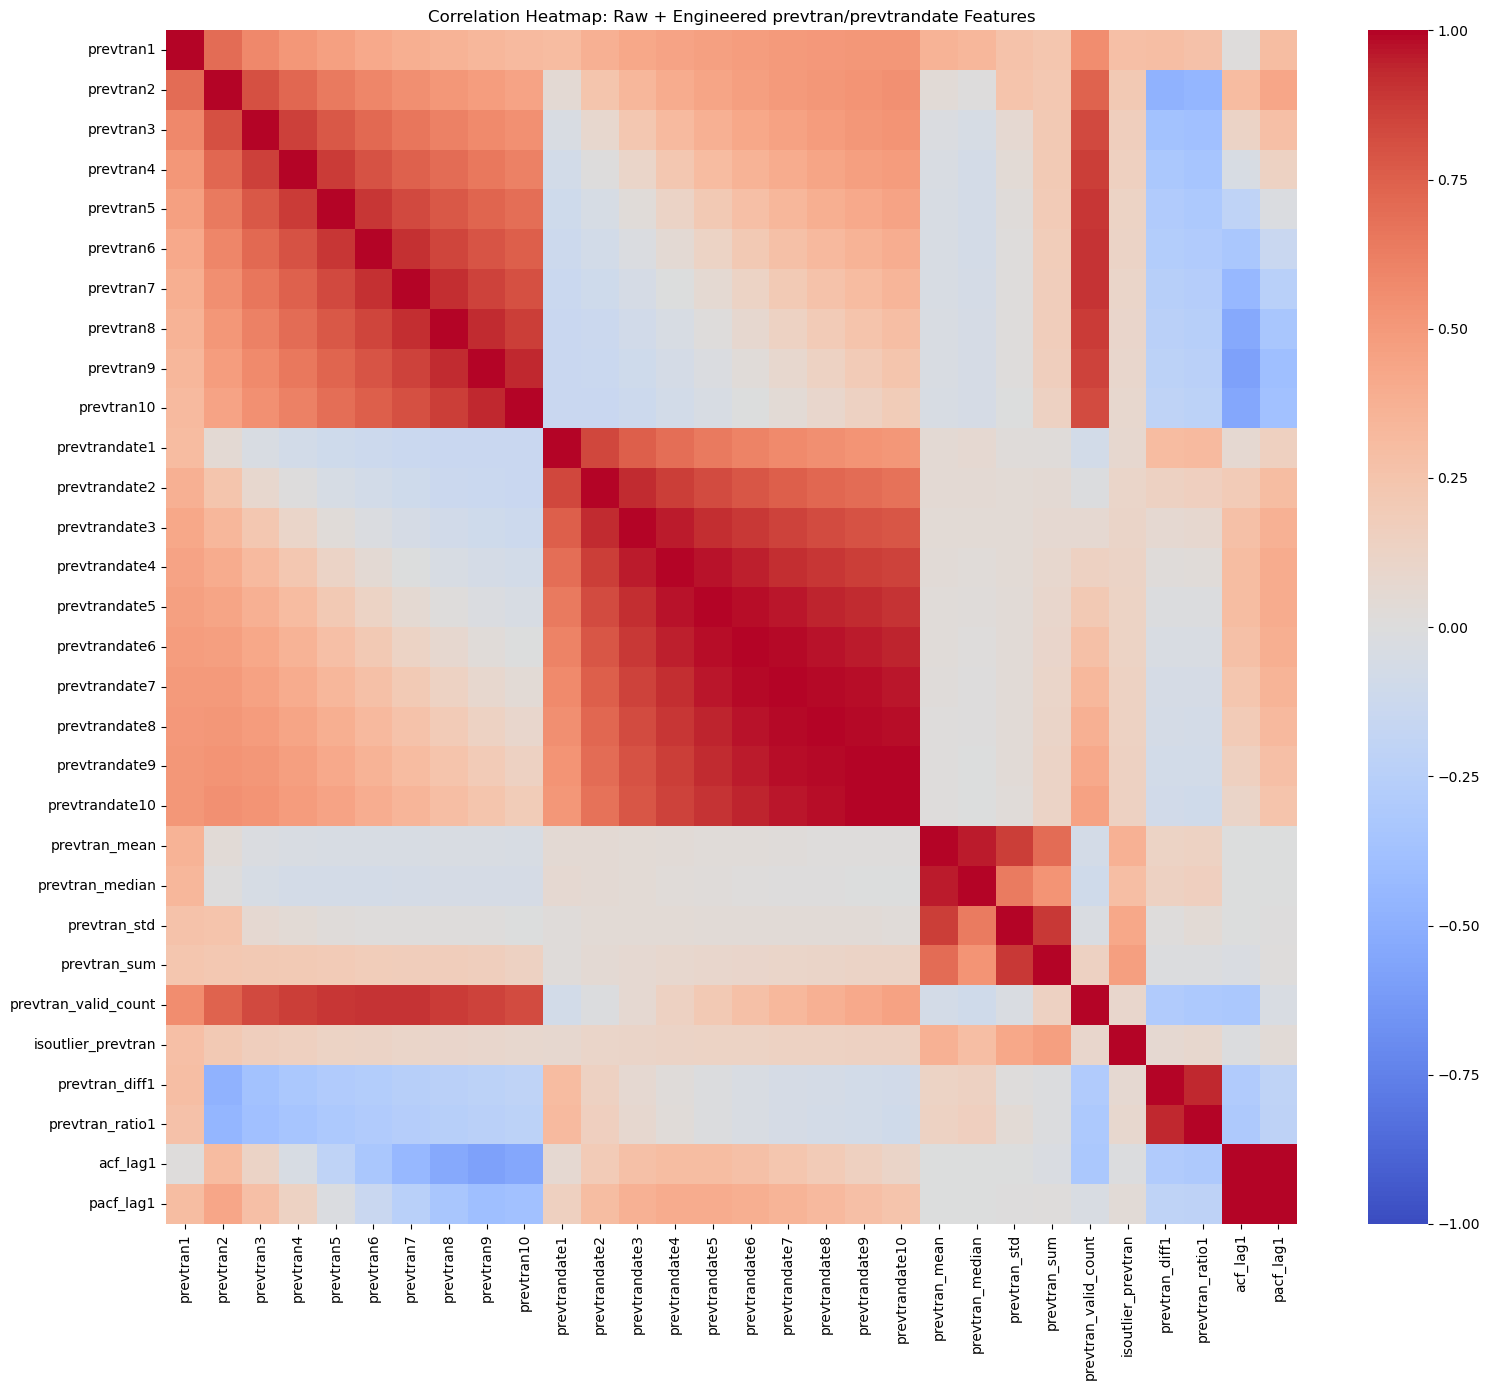

In [44]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(16, 14))
sns.heatmap(corr_matrix, cmap='coolwarm', center=0, vmin=-1, vmax=1)
plt.title("Correlation Heatmap: Raw + Engineered prevtran/prevtrandate Features")
plt.xticks(rotation=90)
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

In [45]:
threshold = 0.9
high_corr = []

for i in range(len(corr_matrix.columns)):
    for j in range(i):
        corr = corr_matrix.iloc[i, j]
        if abs(corr) > threshold:
            high_corr.append((corr_matrix.columns[i], corr_matrix.columns[j], corr))

print("Highly correlated feature pairs (|corr| > 0.9):")
for f1, f2, val in high_corr:
    print(f"  {f1} ↔ {f2}  (corr = {val:.2f})")

Highly correlated feature pairs (|corr| > 0.9):
  prevtran7 ↔ prevtran6  (corr = 0.91)
  prevtran8 ↔ prevtran7  (corr = 0.92)
  prevtran9 ↔ prevtran8  (corr = 0.92)
  prevtran10 ↔ prevtran9  (corr = 0.93)
  prevtrandate3 ↔ prevtrandate2  (corr = 0.93)
  prevtrandate4 ↔ prevtrandate3  (corr = 0.96)
  prevtrandate5 ↔ prevtrandate3  (corr = 0.92)
  prevtrandate5 ↔ prevtrandate4  (corr = 0.97)
  prevtrandate6 ↔ prevtrandate4  (corr = 0.95)
  prevtrandate6 ↔ prevtrandate5  (corr = 0.98)
  prevtrandate7 ↔ prevtrandate4  (corr = 0.92)
  prevtrandate7 ↔ prevtrandate5  (corr = 0.96)
  prevtrandate7 ↔ prevtrandate6  (corr = 0.99)
  prevtrandate8 ↔ prevtrandate5  (corr = 0.94)
  prevtrandate8 ↔ prevtrandate6  (corr = 0.97)
  prevtrandate8 ↔ prevtrandate7  (corr = 0.99)
  prevtrandate9 ↔ prevtrandate5  (corr = 0.92)
  prevtrandate9 ↔ prevtrandate6  (corr = 0.95)
  prevtrandate9 ↔ prevtrandate7  (corr = 0.98)
  prevtrandate9 ↔ prevtrandate8  (corr = 0.99)
  prevtrandate10 ↔ prevtrandate5  (corr = 0

what we want:
- keep only one of a pair if correlation > 0.95
- drop redundent features

obeservations:
- prevtran6–10 highly correlated
- prevtran_mean/median highly correlated
- prevtrandate2–10 highly correlated
- pacf_lag1, acf_lag1 highly correlated

hence:
- only keep prevtran1-6, drop prevtran7–10
- only keep prevtran_mean, drop prevtran_median
- only keep prevtrandate1–3, add prevtrandate_mean, prevtrandate_std
- only keep acf_lag1


In [46]:
from statsmodels.tsa.stattools import acf

def compute_acf_lag1(row):
    x = row.values.astype(float)
    return pd.Series([acf(x, nlags=1, fft=False)[1]])

In [58]:
def prevtran_preprocessing_improved(df):
    '''
    Modified features:
    - prevtran*: impute with 0, log transformation (only keep prevtran1–6, add mean/std/sum/valid_count)
    - prevtrandate*: impute with prev value fallback (only keep prevtrandate1–3, add mean/std)

    Added features:
    - isoutlier_prevtran: flag if any extreme transaction in prevtran*
    - prevtran_diff1: most recent change (prevtran1 - prevtran2)
    - prevtran_ratio1: ratio of most recent to second-most-recent transaction
    - prevtran_mean, prevtran_std, prevtran_sum, prevtran_valid_count
    - acf_lag1: autocorrelation-based temporal pattern
    - prevtrandate_mean, prevtrandate_std
    '''
    
    prevtran_cols = [f'prevtran{i}' for i in range(1, 11)]
    keep_prevtran_cols = [f'prevtran{i}' for i in range(1, 7)]  # keep prevtran1–6
    drop_prevtran_cols = [f'prevtran{i}' for i in range(7, 11)]

    prevtrandate_cols = [f'prevtrandate{i}' for i in range(1, 11)]
    keep_prevtrandate_cols = [f'prevtrandate{i}' for i in range(1, 4)]  # keep prevtrandate1–3
    drop_prevtrandate_cols = [f'prevtrandate{i}' for i in range(4, 11)]


    # Mean, median, std, min, max, and sum across previous transactions, 
    # preserve absence of behavior in the statistics by computing before imputing
    df['prevtran_mean'] = df[prevtran_cols].mean(axis=1, skipna=True)
    df['prevtran_std'] = df[prevtran_cols].std(axis=1, skipna=True)
    df['prevtran_sum'] = df[prevtran_cols].sum(axis=1, skipna=True)
    df['prevtran_valid_count'] = df[prevtran_cols].notnull().sum(axis=1)

    # prevtrandate summary stats
    df['prevtrandate_mean'] = df[prevtrandate_cols].mean(axis=1, skipna=True)
    df['prevtrandate_std'] = df[prevtrandate_cols].std(axis=1, skipna=True)

    # impute missing values
    prevtran_missing_imputation(df)
    prevtrandate_missing_imputation(df)
    if not check_prevtran_imputed:
        raise ValueError(f"Imputation incomplete: Some prevtran/prevtrandate values are still missing.")
    
    # add an isoutlier column to preserve extreme behavior as a signal
    threshold = df[prevtran_cols].stack().quantile(0.99)
    df['isoutlier_prevtran'] = (df[prevtran_cols].max(axis=1) > threshold).astype(int)

    # take log of prevtran1–6, since data right-skewed, clip if using non-tree based methods?
    df[keep_prevtran_cols] = df[keep_prevtran_cols].applymap(lambda x: np.log1p(x) if x > 0 else 0)

    # prevtran_diff1, prevtran_ratio1
    df['prevtran_diff1'] = df['prevtran1'] - df['prevtran2']
    df['prevtran_ratio1'] = df['prevtran1'] / (df['prevtran2'] + 1e-5)
    
    # timeseries features: acf, pacf
    df[['acf_lag1']] = df[keep_prevtran_cols].apply(compute_acf_lag1, axis=1)


    columns_to_drop = (drop_prevtran_cols + drop_prevtrandate_cols)
    df.drop(columns=[col for col in columns_to_drop if col in df.columns], inplace=True)

prevtran_preprocessing_improved(df)

/tmp/ipykernel_1970996/2554303172.py:47: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  df[keep_prevtran_cols] = df[keep_prevtran_cols].applymap(lambda x: np.log1p(x) if x > 0 else 0)
/users/kzhan176/.conda/envs/citizens/lib/python3.12/site-packages/statsmodels/tsa/stattools.py:702: RuntimeWarning: invalid value encountered in divide
  acf = avf[: nlags + 1] / avf[0]


In [59]:
# check preprocessing and feature engineering results

engineered_cols = [
    'prevtran_mean', 'prevtran_std', 'prevtran_sum', 'prevtran_valid_count',
    'isoutlier_prevtran', 'prevtran_diff1', 'prevtran_ratio1',
    'acf_lag1', 'prevtrandate_mean', 'prevtrandate_std'
]

prevtran_cols = [f'prevtran{i}' for i in range(1, 11)]
keep_prevtran_cols = [f'prevtran{i}' for i in range(1, 7)]  # keep prevtran1–6
drop_prevtran_cols = [f'prevtran{i}' for i in range(7, 11)]

prevtrandate_cols = [f'prevtrandate{i}' for i in range(1, 11)]
keep_prevtrandate_cols = [f'prevtrandate{i}' for i in range(1, 4)]  # keep prevtrandate1–3
drop_prevtrandate_cols = [f'prevtrandate{i}' for i in range(4, 11)]

all_corr_cols = keep_prevtran_cols + keep_prevtrandate_cols + engineered_cols

corr_matrix = df[all_corr_cols].corr()

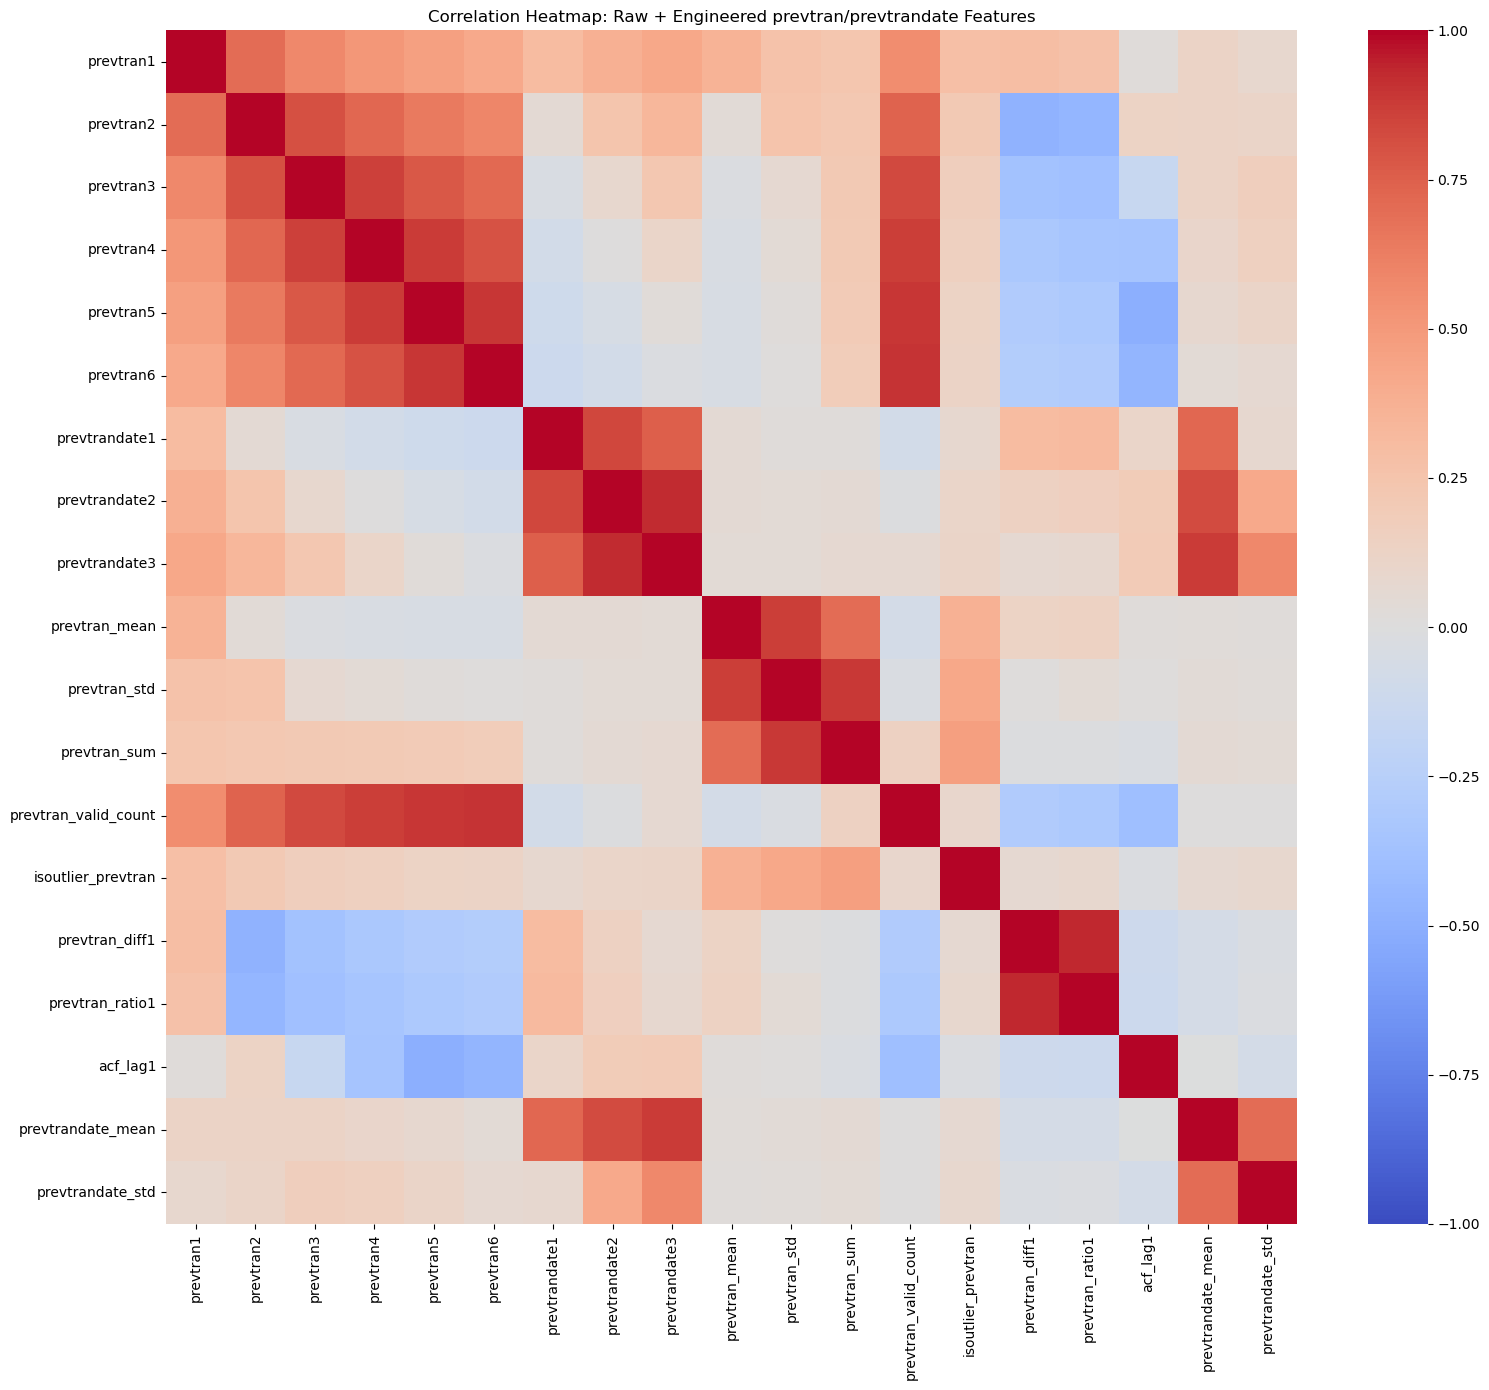

In [60]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(16, 14))
sns.heatmap(corr_matrix, cmap='coolwarm', center=0, vmin=-1, vmax=1)
plt.title("Correlation Heatmap: Raw + Engineered prevtran/prevtrandate Features")
plt.xticks(rotation=90)
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

In [28]:
df['isoutlier_prevtran'].value_counts()

isoutlier_prevtran
0    16687
1     1078
Name: count, dtype: int64

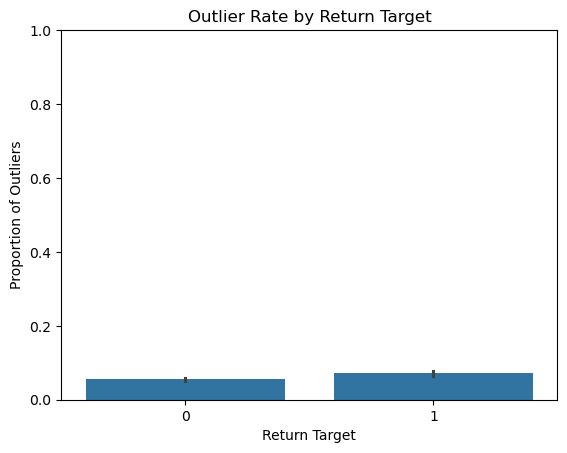

In [29]:
sns.barplot(data=df, x='return_target', y='isoutlier_prevtran')
plt.title('Outlier Rate by Return Target')
plt.ylabel('Proportion of Outliers')
plt.xlabel('Return Target')
plt.ylim(0, 1)
plt.show()

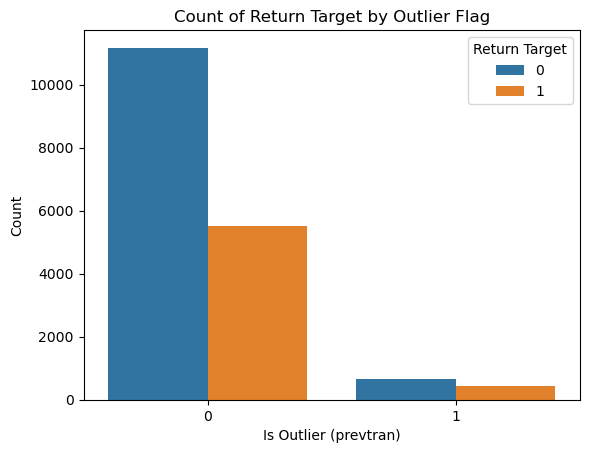

In [31]:
sns.countplot(data=df, x='isoutlier_prevtran', hue='return_target')
plt.title('Count of Return Target by Outlier Flag')
plt.xlabel('Is Outlier (prevtran)')
plt.ylabel('Count')
plt.legend(title='Return Target')
plt.show()

In [33]:
import scipy.stats as stats
contingency = pd.crosstab(df['isoutlier_prevtran'], df['return_target'])
chi2, p, _, _ = stats.chi2_contingency(contingency)
print(f"Chi-square p-value: {p:.8f}")

Chi-square p-value: 0.00000827
